## Demo 2: HKR Classifier on toy dataset

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deel-ai/deel-lip/blob/master/docs/notebooks/demo2.ipynb)

In this demo notebook we will show how to build a robust classifier based on the
regularized version of the Kantorovitch-Rubinstein duality. We will perform this on the
`two moons` synthetic dataset.


In [1]:
# pip install git+https://github.com/deel-ai/deel-lip.git@keras3 -qqq

In [2]:
from functools import partial

import numpy as np
from sklearn.datasets import make_moons, make_circles  # the synthetic dataset
import seaborn as sns


# in order to build our classifier we will use element from tensorflow along with
# layers from deel-lip
import keras
import keras.ops as K
from keras.layers import Input
from keras.optimizers import Adam

from deel.lip.model import Model  # not mandatory but offers the vanilla_export feature
from deel.lip.layers import SpectralDense, FrobeniusDense
from deel.lip.activations import FullSort
from deel.lip.losses import HKR, KR, HingeMargin  # custom losses for HKR robust classif

2024-09-06 15:09:48.071410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 15:09:48.082782: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 15:09:48.086252: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-06 15:09:48.094566: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-06 15:09:49.444317: W tensorflow/compiler/tf2

### Parameters

Let's first construct our two moons dataset


In [3]:
circle_or_moons = 1  # 0 for circle , 1 for moons
n_samples = 5000  # number of sample in the dataset
noise = 0.05  # amount of noise to add in the data. Tested with 0.14 for circles 0.05 for two moons
factor = 0.4  # scale factor between the inner and the outer circle

In [4]:
if circle_or_moons == 0:
    X, Y = make_circles(n_samples=n_samples, noise=noise, factor=factor)
else:
    X, Y = make_moons(n_samples=n_samples, noise=noise)

<Axes: >

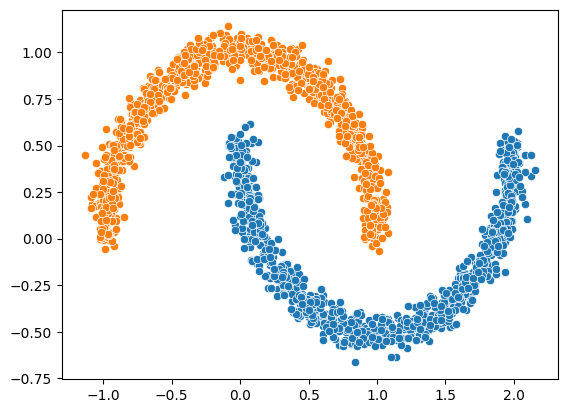

In [5]:
X1 = X[Y == 1]
X2 = X[Y == 0]
sns.scatterplot(x=X1[:1000, 0], y=X1[:1000, 1])
sns.scatterplot(x=X2[:1000, 0], y=X2[:1000, 1])

### Relation with optimal transport

In this setup we can solve the optimal transport problem between the distribution of
`X[Y==1]` and `X[Y==-1]`. This usually require to match each element of the first
distribution with an element of the second distribution such that this minimize a global
cost. In our setup this cost is the $ l_1 $ distance, which will allow us to make use of
the KR dual formulation. The overall cost is then the $W_1$ distance.

#### Wasserstein distance

The wasserstein distance measure the distance between two probability distribution.
Wikipedia article gives a more intuitive definition of it:

> Intuitively, if each distribution is viewed as a unit amount of "dirt" piled on
> {\displaystyle M}M, the metric is the minimum "cost" of turning one pile into the
> other, which is assumed to be the amount of dirt that needs to be moved times the mean
> distance it has to be moved. Because of this analogy, the metric is known in computer
> science as the earth mover's distance.

Mathematically it is defined as:

$$
W_1(\mu,\nu) = \inf_{\pi \in \Pi(\mu,\nu)}\underset{x,z \sim \pi}{\mathbb{E}}\parallel \textbf{x}-\textbf{z} \parallel
$$

where $\Pi(\mu,\nu)$ is the set of all probability measures on $\Omega\times \Omega$
with marginals $\mu$ and $\nu$. In most case this equation is not tractable.

However the $W_1$ distance is known to be untractable in general.

#### KR dual formulation

In our setup, the KR dual formulation is stated as following: $$ W*1(\mu, \nu) = \sup*{f
\in Lip_1(\Omega)} \underset{\textbf{x} \sim \mu}{\mathbb{E}} \left[f(\textbf{x}
)\right] -\underset{\textbf{x} \sim \nu}{\mathbb{E}} \left[f(\textbf{x} )\right] $$

This state the problem as an optimization problem over the 1-lipschitz functions.
Therefore k-Lipschitz networks allows us to solve this maximization problem.

#### Hinge-KR classification

When dealing with $W_1$ one may note that many functions maximize the maximization
problem described above. Also we want this function to be meaningfull in terms of
classification. To do so, we want f to be centered in 0, which can be done without
altering the inital problem. By doing so we can use the obtained function for binary
classification, by looking at the sign of $f$.

In order to enforce this, we will add a Hinge term to the loss. It has been shown that
this new problem is still a optimal transport problem and that this problem admit a
meaningfull optimal solution.


### HKR-Classifier

Now we will show how to build a binary classifier based on the regularized version of
the KR dual problem.

In order to ensure the 1-Lipschitz constraint `deel-lip` uses spectral normalization.
These layers also can also use Bjork orthonormalization to ensure that the gradient of
the layer is 1 almost everywhere. Experiment shows that the optimal solution lie in this
sub-class of functions.


In [6]:
batch_size = 256
steps_per_epoch = 40480
epoch = 10
hidden_layers_size = [256, 128, 64]  # stucture of the network
activation = (
    FullSort  # other lipschitz activation are ReLU, MaxMin, GroupSort2, GroupSort
)
min_margin = 0.29  # minimum margin to enforce between the values of f for each class

In [7]:
# build data generator
def otp_generator(batch_size, X, Y):
    Y_ix = np.array([i for i in range(Y.shape[0])])
    Y0_ix = Y_ix[Y == 0]
    Y1_ix = Y_ix[Y == 1]
    while True:
        batch_x = np.zeros(((batch_size,) + (X[0].shape)), dtype=np.float32)
        batch_y = np.zeros((batch_size, 1), dtype=np.float32)
        ind = np.random.choice(Y0_ix, size=batch_size // 2, replace=False)
        batch_x[: batch_size // 2,] = X[ind]
        batch_y[: batch_size // 2, 0] = Y[ind]
        ind = np.random.choice(Y1_ix, size=batch_size // 2, replace=False)
        batch_x[batch_size // 2 :,] = X[ind]
        batch_y[batch_size // 2 :, 0] = Y[ind]

        yield batch_x, batch_y


gen = otp_generator(batch_size, X, Y)

### Build Lipschitz model

Let's build our model now.


In [8]:
keras.utils.clear_session()
# please note that calling the previous helper function has the exact
# same effect as the following code:
inputs = Input((2,))
x = SpectralDense(256, activation=activation())(inputs)
x = SpectralDense(128, activation=activation())(x)
x = SpectralDense(64, activation=activation())(x)
y = FrobeniusDense(1, activation=None)(x)
wass = Model(inputs=inputs, outputs=y)
wass.summary()

I0000 00:00:1725628191.539264  866183 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725628191.559486  866183 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725628191.559628  866183 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725628191.560274  866183 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_dense (SpectralDense)  │ (None, 256)            │         1,537 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_dense_1                │ (None, 128)            │        65,793 │
│ (SpectralDense)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_dense_2                │ (None, 64)             │        16,513 │
│ (SpectralDense)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ frobenius_dense                 │ (None, 1)              │           129 │
│ (FrobeniusDense)                │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,972 (328.02 KB)

 Trainable params: 41,985 (164.00 KB)

 Non-trainable params: 41,987 (164.01 KB)

As we can see the network has a gradient equal to 1 almost everywhere as all the layers
respect this property.

It is good to note that the last layer is a `FrobeniusDense` this is because, when we
have a single output, it become equivalent to normalize the frobenius norm and the
spectral norm (as we only have a single singular value)


In [9]:
optimizer = Adam(learning_rate=0.01)

In [10]:
wass.compile(
    loss=HKR(
        alpha=10, min_margin=min_margin
    ),  # HKR stands for the hinge regularized KR loss
    metrics=[
        KR,  # shows the KR term of the loss
        HingeMargin(min_margin=min_margin),  # shows the hinge term of the loss
        keras.metrics.BinaryAccuracy(threshold=0),  # shows classif. accuracy
    ],
    optimizer=optimizer,
)

### Learn classification on toy dataset

Now we are ready to learn the classification task on the two moons dataset.


In [11]:
wass.fit(gen, steps_per_epoch=steps_per_epoch // batch_size, epochs=epoch, verbose=1)

Epoch 1/10


I0000 00:00:1725628194.610220  866272 service.cc:146] XLA service 0x56551459f300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725628194.610237  866272 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2024-09-06 15:09:54.657698: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-06 15:09:54.847169: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


 30/158 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - HingeMargin: 0.1231 - KR: 0.0621 - binary_accuracy: 0.5760 - loss: 1.1691

I0000 00:00:1725628197.746760  866272 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - HingeMargin: 0.0607 - KR: 0.5395 - binary_accuracy: 0.7970 - loss: 0.0673
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - HingeMargin: 0.0142 - KR: 1.0956 - binary_accuracy: 0.9555 - loss: -0.9537
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - HingeMargin: 0.0120 - KR: 1.0793 - binary_accuracy: 0.9644 - loss: -0.9595
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - HingeMargin: 0.0122 - KR: 1.0846 - binary_accuracy: 0.9641 - loss: -0.9624
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - HingeMargin: 0.0134 - KR: 1.1011 - binary_accuracy: 0.9597 - loss: -0.9673
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - HingeMargin: 0.0116 - KR: 1.0947 - binary_accuracy: 0.9646 - loss: -0.9783
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - HingeMargin: 0.0131 - KR: 1.0943 - binary_accuracy: 0.9606 - loss: -0.9629
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - HingeMargin: 0.0120 - KR: 1.0945 - binary_accura

### Plot output contour line

As we can see the classifier get a pretty good accuracy. Let's now take a look at the
learnt function. As we are in the 2D space, we can draw a countour plot to visualize f.


In [12]:
import matplotlib.pyplot as plt

batch_size = 1024

x = np.linspace(X[:, 0].min() - 0.2, X[:, 0].max() + 0.2, 120)
y = np.linspace(X[:, 1].min() - 0.2, X[:, 1].max() + 0.2, 120)
xx, yy = np.meshgrid(x, y, sparse=False)
X_pred = np.stack((xx.ravel(), yy.ravel()), axis=1)

In [13]:
# make predictions of f
pred = wass.predict(X_pred)

Y_pred = pred
Y_pred = Y_pred.reshape(x.shape[0], y.shape[0])

450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step


<a list of 7 text.Text objects>

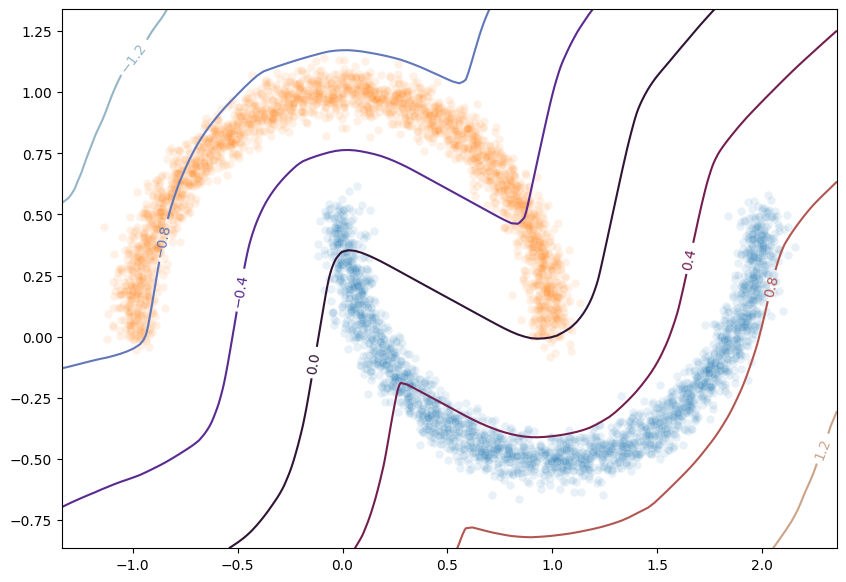

In [14]:
# plot the results
fig = plt.figure(figsize=(10, 7))
ax1 = fig.add_subplot(111)

sns.scatterplot(x=X[Y == 1, 0], y=X[Y == 1, 1], alpha=0.1, ax=ax1)
sns.scatterplot(x=X[Y == 0, 0], y=X[Y == 0, 1], alpha=0.1, ax=ax1)
cset = ax1.contour(xx, yy, Y_pred, cmap="twilight")
ax1.clabel(cset, inline=1, fontsize=10)

### Transfer network to a classical MLP and compare outputs

As we saw, our networks use custom layers in order to constrain training. However during
inference layers behave exactly as regular `Dense` or `Conv2d` layers. Deel-lip has a
functionnality to export a model to it's vanilla keras equivalent. Making it more
convenient for inference.


In [15]:
from deel.lip.model import vanillaModel

## this is equivalent to test2 = wass.vanilla_export()
test2 = vanillaModel(wass)
test2.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor (InputLayer)       │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_dense (Dense)          │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_dense_1 (Dense)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_dense_2 (Dense)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ frobenius_dense (Dense)         │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,985 (164.00 KB)

 Trainable params: 41,985 (164.00 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
pred_test = test2.predict(X_pred)
Y_pred = pred_test
Y_pred = Y_pred.reshape(x.shape[0], y.shape[0])

450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step


<a list of 7 text.Text objects>

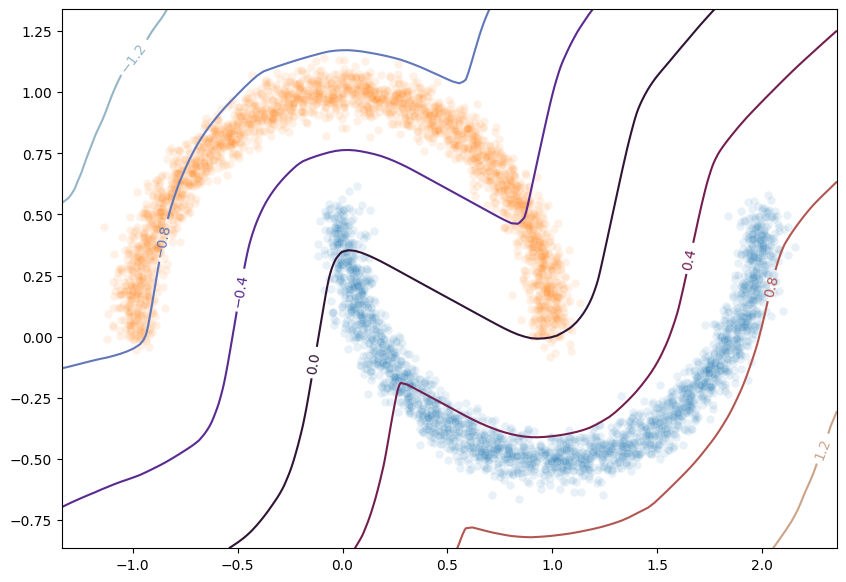

In [17]:
fig = plt.figure(figsize=(10, 7))
ax1 = fig.add_subplot(111)
sns.scatterplot(x=X[Y == 1, 0], y=X[Y == 1, 1], alpha=0.1, ax=ax1)
sns.scatterplot(x=X[Y == 0, 0], y=X[Y == 0, 1], alpha=0.1, ax=ax1)
cset = ax1.contour(xx, yy, Y_pred, cmap="twilight")
ax1.clabel(cset, inline=1, fontsize=10)